# Step 4
## Add Synonyms and Edges to Base Graph

So now that we have a base graph, we can start applying the synonyms.

### General Steps
1. Initialize synonym dictionary.
    * This is separate from the original spa dictionary.
    We want to allow the same words between SPA and the SYN. 
    We are not performing TF-IDF over the syns, they only exist for the relationship between different words in SPA.
2. For each poem, bring up it's base graph
3. Iterate over the nodes in the base graph.
4. Determine synonyms for the node.
5. Iterate over the synonyms.
6. If the synonym is new, add it to the SYN dictionary.
7. Add the syn node to the graph, if it does not already exist.
8. Create an edge between the original SPA node and the newly added syn node.

In [1]:
import os
from copy import deepcopy

import networkx as nx
from gensim.corpora import Dictionary
from gensim import corpora
from nltk.corpus import wordnet as wn

In [2]:
spa_dictionary = Dictionary.load('../data/spa.dict')

# 16905 is the number of nodes created from just the SPA terms
node_id_start = 16905 + 1

In [3]:
syn_to_node_hash = dict()
syn_dictionary = corpora.Dictionary()

for ind, file in enumerate(os.listdir('../data/base_graphs/')):
    if ind % 10 == 1:
        print(ind)
    
    graph = nx.read_gpickle(f'../data/base_graphs/{file}')
    
    syn_nodes = dict()
    
    # So the size doesnt change during iteration
    graph_nodes = deepcopy(graph.nodes(data=True))
    
    for node, data in graph_nodes:
        term = spa_dictionary[data['term_id']]
        
        # make a call to the wordnet synsets api for the syns associated with the term
        term_syns = wn.synsets(term)
        
        for syn_obj in term_syns:
            # extracts the text value from the syn object
            syn = syn_obj.name().split('.')[0]
            
            # has not been added to this graph
            if syn not in syn_nodes:
                
                # Make sure the synonym gets added to the dictionary
                if syn not in syn_dictionary.token2id:
                    syn_dictionary.add_documents([[syn]])
                
                # has not been seen yet across all graphs
                if syn not in syn_to_node_hash:
                    syn_to_node_hash[syn] = ((
                        node_id_start,
                        {
                            'doc_id': -1,
                            'tf_idf': -1,
                            'term_id': syn_dictionary.token2id[syn],
                            'type': 'SYN'
                        }
                    ))
                    
                    node_id_start += 1
                    
                graph.add_node(
                    syn_to_node_hash[syn][0],
                    **syn_to_node_hash[syn][1]
                )
                
            # add edge between spa node and syn
            graph.add_edge(
                node,
                syn_to_node_hash[syn][0]
            )
            
    nx.write_gpickle(graph, f'../data/base_graphs/{file}')
    
# Save off the syn dictionary.
syn_dictionary.save('../data/syn.dict')
print('Done')

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241


### To help visualize progress. 

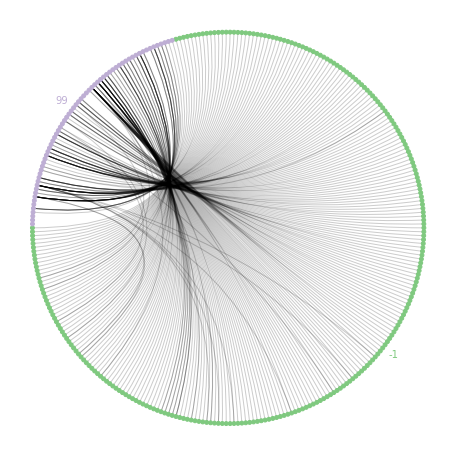

In [5]:
import nxviz as nv
import matplotlib.pyplot as plt

% matplotlib inline

ap = nv.CircosPlot(
    graph, 
    node_color='doc_id', 
    node_order='doc_id', 
    node_grouping='doc_id', 
    group_label_position='middle',
    group_label_color=True,
    figsize=(8, 8)
)

ap.draw()
plt.show();